In [1]:
from funlib.persistence import open_ds, prepare_ds, Array

import matplotlib.pyplot as plt
import numpy as np
import dask.array as da
from matplotlib.widgets import Slider
from scipy.ndimage import gaussian_filter
from pathlib import Path
from skimage.morphology import remove_small_objects
from skimage.measure import label


In [2]:
zarr_path = Path("/media/riware/One Touch/Rachel_Ware/kidney_segmentation/full_pipeline_preds_fall2025/full_pipeline_preds_11Nov2025/21-2002 A-1-9 Trich - 2021-03-22 12.36.47.zarr")
fibrosis_array = open_ds(zarr_path / "mask" / "finfib")
path_data_array = open_ds(zarr_path / "raw" / "s0")

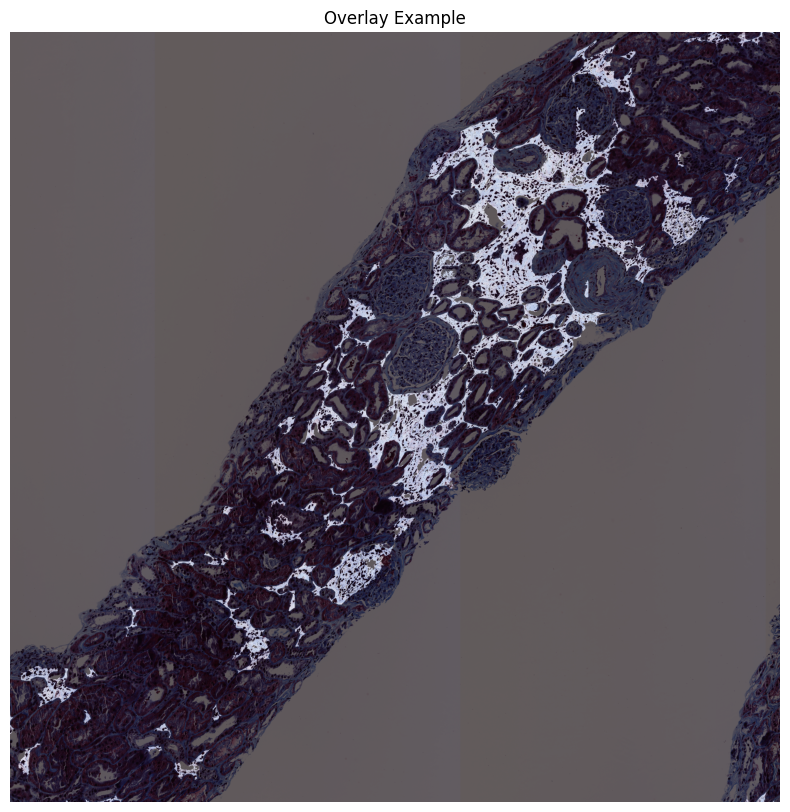

In [3]:
# --------------------------------------------
# Choose a section (crop) to visualize
# --------------------------------------------
# Define a crop for visualization (adjust these coordinates as you like).
y0, x0 = 30000, 14000
h, w = 10000, 10000
crop = (slice(y0, y0 + h), slice(x0, x0 + w))
# compute the crops for visualization
orig_crop = path_data_array.data[crop].compute()
orig_crop_fib = (fibrosis_array.data[crop].compute() > 1).astype(float)

# Visualize Crops
fig, ax = plt.subplots(figsize=(10, 10))
# Show first image
ax.imshow(orig_crop)
# Overlay second image with transparency
ax.imshow(orig_crop_fib, cmap='hot', alpha=0.6)  # alpha controls transparency
ax.set_title('Overlay Example')
ax.axis('off')

plt.show()

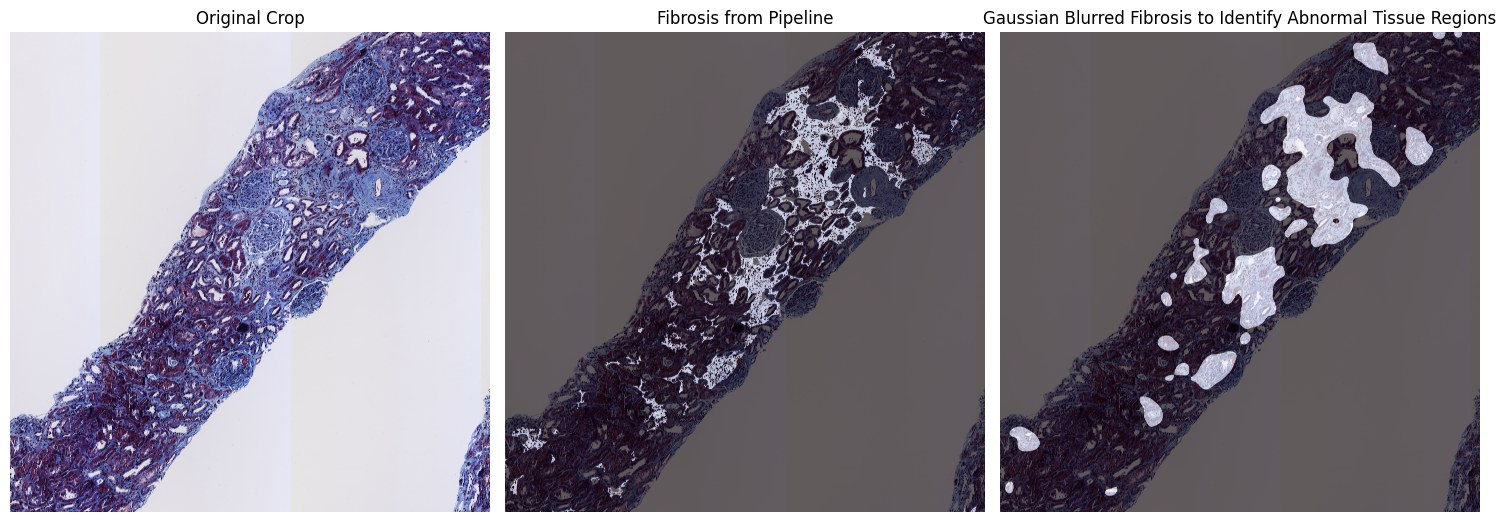

In [44]:
# --------------------------------------------
# Initial blur + figure setup - no downsampling
# --------------------------------------------
initial_sigma = 91.0
initial_truncate = 4.0

vmin, vmax = float(orig_crop_fib.min()), float(orig_crop_fib.max())

# Compute initial blurred crop
blurred_crop = gaussian_filter(orig_crop_fib, sigma = initial_sigma, truncate = initial_truncate) > 0.2

# --- Plot side-by-side ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

# Left image
im1 = ax1.imshow(orig_crop)
ax1.set_title('Original Crop')
ax1.axis('off')

# Middle image + overlay
im2 = ax2.imshow(orig_crop)
ax2.imshow(orig_crop_fib, cmap='hot', alpha=0.6)
ax2.set_title('Fibrosis from Pipeline')
ax2.axis('off')

# Right image + overlay
im3 = ax3.imshow(orig_crop)
ax3.imshow(blurred_crop, cmap='hot', alpha=0.6)
ax3.set_title('Gaussian Blurred Fibrosis to Identify Abnormal Tissue Regions')
ax3.axis('off')

plt.tight_layout()
plt.show()

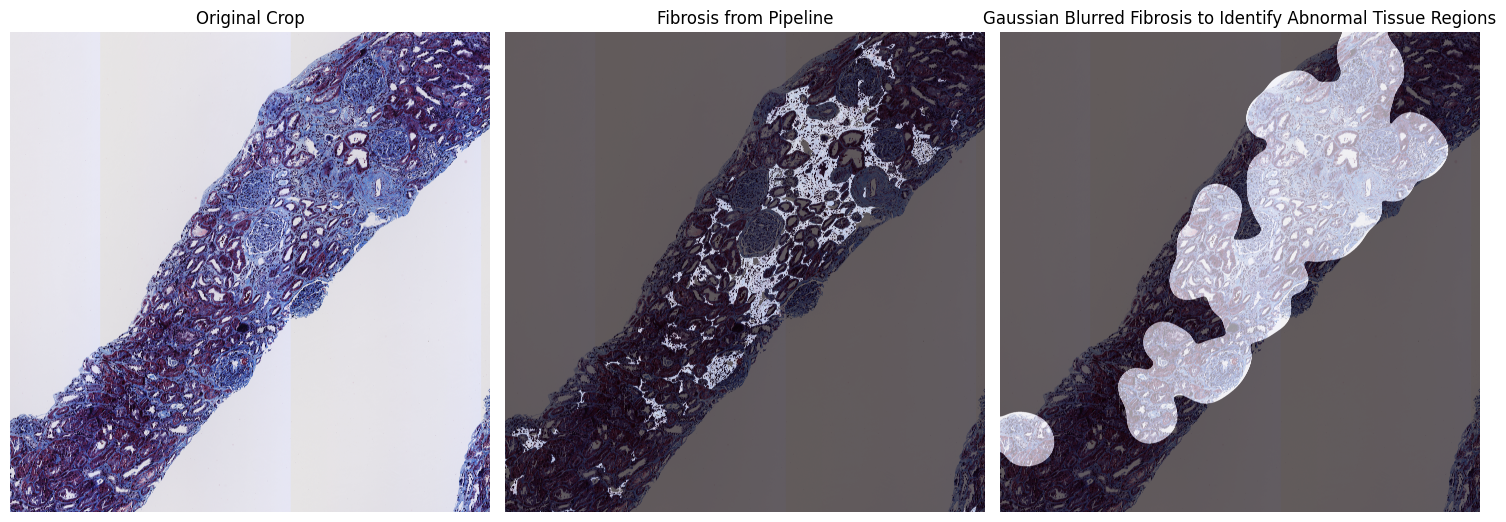

In [ ]:
# --------------------------------------------
# Initial blur + figure setup - downsampling
# --------------------------------------------
initial_sigma = 41.0
initial_truncate = 4.0

vmin, vmax = float(orig_crop_fib.min()), float(orig_crop_fib.max())

# downsample 
downsample_factor = 4 
new_shape = (
    orig_crop_fib.shape[0] // downsample_factor,
    downsample_factor,
    orig_crop_fib.shape[1] // downsample_factor,
    downsample_factor,
    )
downsampled_fib = orig_crop_fib.reshape(new_shape).mean(axis=(1, 3))
labeled = label(downsampled_fib.astype(bool), connectivity=2)
filtered_fib = remove_small_objects(labeled.astype(bool), min_size=3000)

# Compute initial blurred crop
blurred_crop = gaussian_filter(filtered_fib.astype(float), sigma = initial_sigma, truncate = initial_truncate) > 0.01

# upsample 
upsampling_factor = 4
reps = upsampling_factor
upsampled_fib0 = np.repeat(blurred_crop, reps, axis=0)
upsampled_fib = np.repeat(upsampled_fib0, reps, axis=1)

# --- Plot side-by-side ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

# Left image
im1 = ax1.imshow(orig_crop)
ax1.set_title('Original Crop')
ax1.axis('off')

# Middle image + overlay
im2 = ax2.imshow(orig_crop)
ax2.imshow(orig_crop_fib, cmap='hot', alpha=0.6)
ax2.set_title('Fibrosis from Pipeline')
ax2.axis('off')

# Right image + overlay
im3 = ax3.imshow(orig_crop)
ax3.imshow(upsampled_fib, cmap='hot', alpha=0.6)
ax3.set_title('Gaussian Blurred Fibrosis to Identify Abnormal Tissue Regions')
ax3.axis('off')

plt.tight_layout()
plt.show()

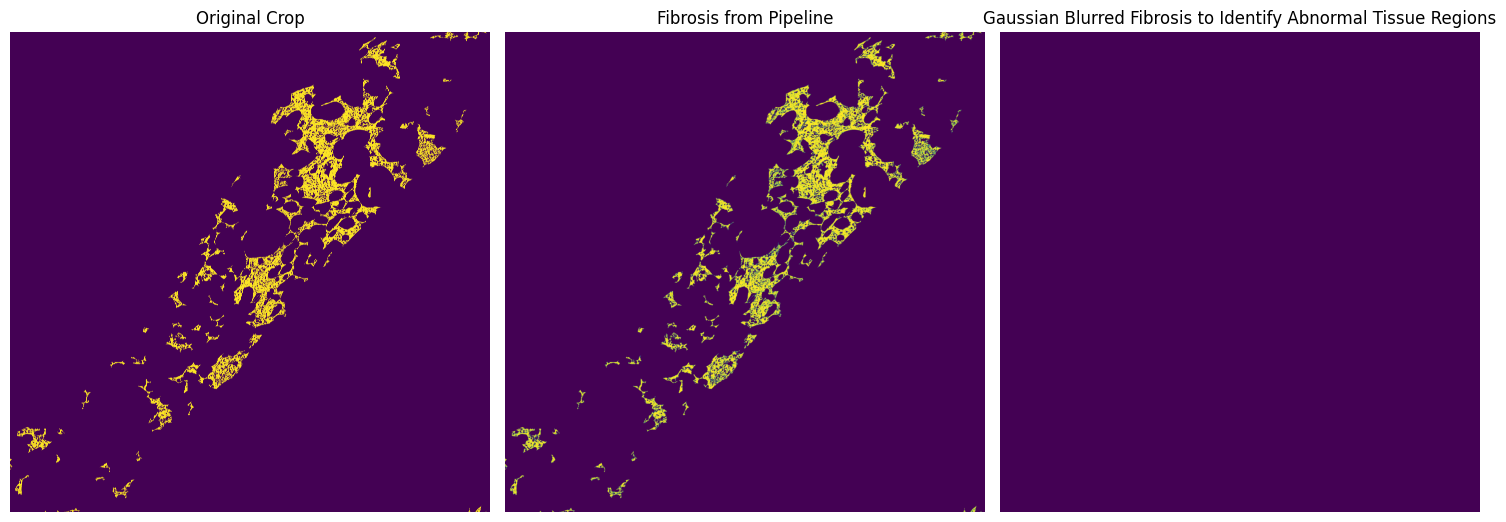

In [6]:
# --- Plot side-by-side ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

# Left image
im1 = ax1.imshow(orig_crop_fib)
ax1.set_title('Original Crop')
ax1.axis('off')

# Middle image + overlay
im2 = ax2.imshow(downsampled_fib)
ax2.set_title('Fibrosis from Pipeline')
ax2.axis('off')

# Right image + overlay
im3 = ax3.imshow(blurred_crop)
ax3.set_title('Gaussian Blurred Fibrosis to Identify Abnormal Tissue Regions')
ax3.axis('off')

plt.tight_layout()
plt.show()
